In [1]:
import glob
import os

import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import plotly.io

from helpers.cell_type_naming import nice_to_weirds, weird_to_nice

plotly.io.renderers.default = "jupyterlab+png"

In [2]:
# PARAM
results_dir = "5d_results_noise_0.01"

### load tirosh sc data

In [3]:
sc_rna_seq = pd.read_csv(
    "gs://liulab/ftp/GSE115978/GSE115978_tpm.csv",
    index_col=0,
).rename_axis(index="GeneSymbol", columns="cells")

g = len(sc_rna_seq)

sc_rna_seq

cells       cy78_CD45_neg_1_B04_S496_comb  \
GeneSymbol                                  
C9orf152                         0.000000   
RPS11                            8.144184   
ELMO2                            2.639232   
CREB3L1                          0.000000   
PNMA1                            3.656496   
...                                   ...   
PIK3IP1                          0.936591   
SNRPD2                           5.374866   
SLC39A6                          3.326681   
CTSC                             2.612352   
AQP7                             0.000000   

cells       cy79_p4_CD45_neg_PDL1_neg_E11_S1115_comb  CY88_5_B10_S694_comb  \
GeneSymbol                                                                   
C9orf152                                    0.000000              0.000000   
RPS11                                       5.915091              7.243164   
ELMO2                                       0.000000              0.732052   
CREB3L1                                     0.000000              0.000000   
PNMA1                                       0.000000              0.536053   
...                                              ...                   ...   
PIK3IP1                                     5.761498              0.000000   
SNRPD2                                      0.000000              5.437661   
SLC39A6                                     0.000000              1.308011   
CTSC                                        0.000000              2.361768   
AQP7                                        0.000000              0.000000   

cells       cy79_p1_CD45_neg_PDL1_pos_AS_C1_R1_F07_S67_comb  \
GeneSymbol                                                    
C9orf152                                           0.000000   
RPS11                                              6.019502   
ELMO2                                              3.687956   
CREB3L1                                            0.000000   
PNMA1                                              3.041418   
...                                                     ...   
PIK3IP1                                            0.000000   
SNRPD2                                             6.240581   
SLC39A6                                            3.516141   
CTSC                                               1.094236   
AQP7                                               0.000000   

cells       cy78_CD45_neg_3_H06_S762_comb  \
GeneSymbol                                  
C9orf152                         0.000000   
RPS11                            7.974753   
ELMO2                            2.599318   
CREB3L1                          0.000000   
PNMA1                            4.132741   
...                                   ...   
PIK3IP1                          2.034216   
SNRPD2                           5.946754   
SLC39A6                          3.868390   
CTSC                             1.934705   
AQP7                             0.000000   

cells       cy79_p1_CD45_neg_PDL1_pos_AS_C1_R1_G01_S73_comb  \
GeneSymbol                                                    
C9orf152                                           0.000000   
RPS11                                              5.557257   
ELMO2                                              1.691087   
CREB3L1                                            0.000000   
PNMA1                                              2.827006   
...                                                     ...   
PIK3IP1                                            0.000000   
SNRPD2                                             4.628132   
SLC39A6                                            1.791189   
CTSC                                               0.852798   
AQP7                                               0.000000   

cells       cy79_p1_CD45_neg_PDL1_neg_AS_C4_R1_D09_S141_comb  \
GeneSymbol                                                     
C9orf152                                     

In [4]:
sc_rna_seq_metadata = pd.read_csv(
    "gs://liulab/ftp/GSE115978/GSE115978_cell.annotations.csv",
).replace({"cell.types": weird_to_nice})

sc_rna_seq_metadata

cells samples cell.types  \
0                       cy78_CD45_neg_1_B04_S496_comb   Mel78  Malignant   
1            cy79_p4_CD45_neg_PDL1_neg_E11_S1115_comb   Mel79  Malignant   
2                                CY88_5_B10_S694_comb   Mel88  Malignant   
3     cy79_p1_CD45_neg_PDL1_pos_AS_C1_R1_F07_S67_comb   Mel79  Malignant   
4                       cy78_CD45_neg_3_H06_S762_comb   Mel78  Malignant   
...                                               ...     ...        ...   
7181                CY75_1_CD45_CD8_3__S168_comb_BCD8   Mel75      T CD8   
7182                CY75_1_CD45_CD8_8__S338_comb_BCD8   Mel75      T CD8   
7183                       monika_D7_S132_comb_BCD8_3   Mel75      T CD8   
7184                CY75_1_CD45_CD8_8__S289_comb_BCD8   Mel75      T CD8   
7185                CY75_1_CD45_CD8_8__S351_comb_BCD8   Mel75      T CD8   

      treatment.group  Cohort  no.of.genes  no.of.reads  
0      post.treatment  Tirosh         8258       357919  
1     treatment.naive  Tirosh         2047         5727  
2      post.treatment  Tirosh         5375       139218  
3     treatment.naive  Tirosh         5648        73996  
4      post.treatment  Tirosh         7409       380341  
...               ...     ...          ...          ...  
7181   post.treatment  Tirosh         3530       137245  
7182   post.treatment  Tirosh         3872       106432  
7183   post.treatment  Tirosh         4589       908173  
7184   post.treatment  Tirosh         4614       140903  
7185   post.treatment  Tirosh         3859       222239  

[7186 rows x 7 columns]

In [5]:
sc_rna_seq_metadata["cell.types"].value_counts().sort_index()

?               307
B               818
CAF             106
Endothelial     104
Macrophage      420
Malignant      2018
NK               92
T CD4           856
T CD8          1759
T.cell          706
Name: cell.types, dtype: int64

In [6]:
cell_types = list(sorted(
    cell_type
    for cell_type in sc_rna_seq_metadata["cell.types"].unique()
    if cell_type not in ["?"]
))

c = len(cell_types)

cell_types

['B',
 'CAF',
 'Endothelial',
 'Macrophage',
 'Malignant',
 'NK',
 'T CD4',
 'T CD8',
 'T.cell']

In [7]:
s = 100  # number of samples
samples = pd.Series([f"sample_{j:0{len(str(s))}d}" for j in range(s)], name="Mixture")
samples

0     sample_000
1     sample_001
2     sample_002
3     sample_003
4     sample_004
         ...    
95    sample_095
96    sample_096
97    sample_097
98    sample_098
99    sample_099
Name: Mixture, Length: 100, dtype: object

In [8]:
rng = np.random.default_rng(seed=0)

proportions = rng.dirichlet((0.5,) * c, size=(s,))
fraction_values = np.array([rng.multinomial(50, p) for p in proportions]) / 50

fractions = pd.DataFrame(
    fraction_values,
    index=samples,
    columns=cell_types
)

fractions_and_empty_csx_metrics = fractions.copy()
fractions_and_empty_csx_metrics[["P-value", "Correlation", "RMSE"]] = (0, 0, 0)

fractions_and_empty_csx_metrics.head()
# how sparse are the counts?
# print((cell_type_counts_per_sample == 0).mean())

fractions_and_empty_csx_metrics

B   CAF  Endothelial  Macrophage  Malignant    NK  T CD4  \
Mixture                                                                   
sample_000  0.04  0.00         0.16        0.16       0.02  0.16   0.14   
sample_001  0.04  0.00         0.18        0.22       0.24  0.18   0.00   
sample_002  0.06  0.14         0.06        0.02       0.00  0.34   0.38   
sample_003  0.04  0.08         0.00        0.10       0.02  0.26   0.06   
sample_004  0.12  0.00         0.00        0.08       0.00  0.30   0.00   
...          ...   ...          ...         ...        ...   ...    ...   
sample_095  0.28  0.02         0.08        0.06       0.12  0.00   0.06   
sample_096  0.04  0.10         0.00        0.02       0.00  0.12   0.06   
sample_097  0.46  0.04         0.02        0.04       0.00  0.44   0.00   
sample_098  0.00  0.44         0.04        0.00       0.40  0.02   0.08   
sample_099  0.08  0.00         0.04        0.00       0.48  0.16   0.00   

            T CD8  T.cell  P-value  Correlation  RMSE  
Mixture                                                
sample_000   0.10    0.22        0            0     0  
sample_001   0.08    0.06        0            0     0  
sample_002   0.00    0.00        0            0     0  
sample_003   0.10    0.34        0            0     0  
sample_004   0.50    0.00        0            0     0  
...           ...     ...      ...          ...   ...  
sample_095   0.22    0.16        0            0     0  
sample_096   0.66    0.00        0            0     0  
sample_097   0.00    0.00        0            0     0  
sample_098   0.02    0.00        0            0     0  
sample_099   0.22    0.02        0            0     0  

[100 rows x 12 columns]

In [9]:
cell_type_single_cells = {
    cell_type: sc_rna_seq_metadata.set_index(["cell.types", "cells"]).loc[cell_type].index.tolist()
    for cell_type in cell_types
}

for cell_type, stuff in cell_type_single_cells.items():
    print(cell_type, len(stuff))

B 818
CAF 106
Endothelial 104
Macrophage 420
Malignant 2018
NK 92
T CD4 856
T CD8 1759
T.cell 706


In [10]:
n_cells_per_gep = 5  # PARAM
# note - increasing this param increases the correlation between sample GEPs per cell type

rng = np.random.default_rng(seed=0)

def make_a_cell_type_gep(cell_type, n_cells_per_gep=5):
    # sample with replacement from single cell data
    sampled_cells = rng.choice(cell_type_single_cells[cell_type], n_cells_per_gep)
    gep = sc_rna_seq[sampled_cells].mean(axis='columns')
    gep *= 100000 / gep.sum()
    return gep

sample_cell_type_geps = pd.concat({
    sample: pd.DataFrame({
        cell_type: make_a_cell_type_gep(cell_type, n_cells_per_gep) 
        for cell_type in cell_types
    })
    for sample in samples
}).rename_axis(columns="cell_type")

In [11]:
sample_cell_type_geps

cell_type                      B        CAF  Endothelial  Macrophage  \
           GeneSymbol                                                  
sample_000 C9orf152     0.000000   0.000000     0.000000    0.000000   
           RPS11       93.816258  53.313483    53.516824   63.651543   
           ELMO2        8.408418   4.196476     0.000000    9.479460   
           CREB3L1      0.000000   3.528394     0.000000    0.000000   
           PNMA1        0.000000   7.129496     0.000000   10.595397   
...                          ...        ...          ...         ...   
sample_099 PIK3IP1     23.716328   9.386941    12.227121   10.196701   
           SNRPD2      22.332987  36.335604    23.037060   24.116396   
           SLC39A6      0.000000   7.024601     2.172527    0.456731   
           CTSC        14.836136  21.366938    21.087523   50.712171   
           AQP7         0.000000   0.000000     0.000000    0.000000   

cell_type              Malignant         NK      T CD4      T CD8     T.cell  
           GeneSymbol                                                         
sample_000 C9orf152     0.000000   0.000000   0.000000   0.000000   0.000000  
           RPS11       47.819273  68.389910  80.802680  70.155542  80.431608  
           ELMO2        8.411707   4.012140   0.000000   0.000000   0.000000  
           CREB3L1      0.000000   0.000000   0.000000   0.000000   0.000000  
           PNMA1        6.471376   0.000000  21.576479   0.000000   0.000000  
...                          ...        ...        ...        ...        ...  
sample_099 PIK3IP1      5.866825  59.486713  49.675969  17.586380  26.995471  
           SNRPD2      32.215756  31.198037  58.317783  43.346368  18.968989  
           SLC39A6     18.572938   0.000000  10.260685   0.000000   2.905304  
           CTSC        18.656793  23.269415  18.724944  38.545707  26.495049  
           AQP7         0.000000   0.000000   0.000000   0.000000   0.000000  

[2368600 rows x 9 columns]

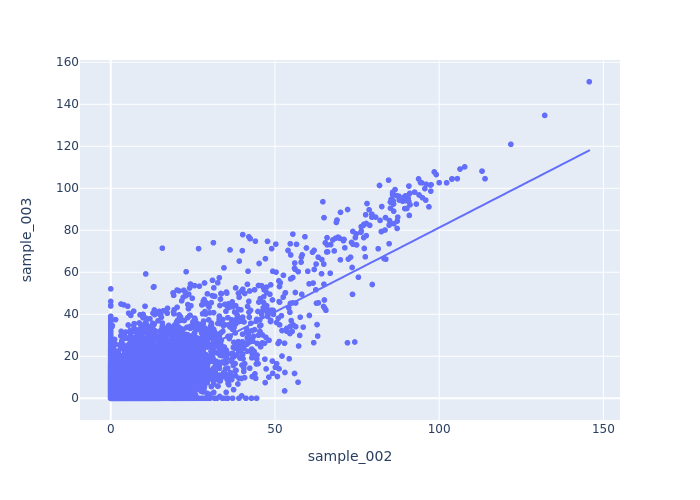

In [12]:
px.scatter(
    sample_cell_type_geps["B"].unstack(0),
    x="sample_002",
    y="sample_003",
    trendline="ols")

In [13]:
fractions

B   CAF  Endothelial  Macrophage  Malignant    NK  T CD4  \
Mixture                                                                   
sample_000  0.04  0.00         0.16        0.16       0.02  0.16   0.14   
sample_001  0.04  0.00         0.18        0.22       0.24  0.18   0.00   
sample_002  0.06  0.14         0.06        0.02       0.00  0.34   0.38   
sample_003  0.04  0.08         0.00        0.10       0.02  0.26   0.06   
sample_004  0.12  0.00         0.00        0.08       0.00  0.30   0.00   
...          ...   ...          ...         ...        ...   ...    ...   
sample_095  0.28  0.02         0.08        0.06       0.12  0.00   0.06   
sample_096  0.04  0.10         0.00        0.02       0.00  0.12   0.06   
sample_097  0.46  0.04         0.02        0.04       0.00  0.44   0.00   
sample_098  0.00  0.44         0.04        0.00       0.40  0.02   0.08   
sample_099  0.08  0.00         0.04        0.00       0.48  0.16   0.00   

            T CD8  T.cell  
Mixture                    
sample_000   0.10    0.22  
sample_001   0.08    0.06  
sample_002   0.00    0.00  
sample_003   0.10    0.34  
sample_004   0.50    0.00  
...           ...     ...  
sample_095   0.22    0.16  
sample_096   0.66    0.00  
sample_097   0.00    0.00  
sample_098   0.02    0.00  
sample_099   0.22    0.02  

[100 rows x 9 columns]

In [14]:
rng = np.random.default_rng(seed=0)

# PARAM -- set noise level
mixture_noise = rng.uniform(low=0.99, high=1.01, size=(g, s))

mixtures = pd.DataFrame({
    sample: sample_cell_type_geps.loc[sample] @ fractions.loc[sample]
    for sample in samples
}) * mixture_noise

mixtures

sample_000  sample_001  sample_002  sample_003  sample_004  \
GeneSymbol                                                               
C9orf152      0.000000    0.000000    0.000000    0.113936    0.000000   
RPS11        70.393058   66.059304   76.506949   70.777838   85.429112   
ELMO2         2.653622    6.104957    6.059130    9.284876    3.297257   
CREB3L1       0.000000    0.000000    0.921310    1.738462    0.000000   
PNMA1         4.816536    5.402467    1.609020    1.816755    4.195601   
...                ...         ...         ...         ...         ...   
PIK3IP1      29.746884   10.371488   11.283866   26.199119   15.639530   
SNRPD2       30.431913   21.889227   33.801747   24.526214   40.921081   
SLC39A6       2.738411   11.355813    4.601354    4.509718    3.188050   
CTSC         39.129812   32.521016   23.981021   35.456511   33.492150   
AQP7          0.000000    0.000000    0.000000    0.000000    0.000000   

            sample_005  sample_006  sample_007  sample_008  sample_009  ...  \
GeneSymbol                                                              ...   
C9orf152      0.000000    0.000000    0.000000    0.000000    0.000000  ...   
RPS11        79.912348   84.522203   73.597919   63.076412   72.116446  ...   
ELMO2         7.556386    2.119290    2.754821   10.475786    5.903501  ...   
CREB3L1       0.714377    0.342705    0.000000    0.000000    1.026391  ...   
PNMA1         3.320023    3.012975    0.832948    6.231908    5.648040  ...   
...                ...         ...         ...         ...         ...  ...   
PIK3IP1      20.278668   29.348149   27.109497   13.635847   23.182550  ...   
SNRPD2       38.150920   31.071817   41.338404   30.491893   30.043196  ...   
SLC39A6      11.827283    2.869759    3.666742    6.640678    4.887003  ...   
CTSC         26.691071   25.432304   26.333984   43.398353   24.602342  ...   
AQP7          0.452812    0.077757    0.253156    0.000000    1.894086  ...   

            sample_090  sample_091  sample_092  sample_093  sample_094  \
GeneSymbol                                                               
C9orf152      0.000000    0.000000    0.000000    0.000000    0.000000   
RPS11        85.593236   66.400375   71.882069   71.658082   65.280382   
ELMO2         3.656008    6.992299    8.289898    4.492528    9.572879   
CREB3L1       1.224416    0.526376    0.000000    0.384908    2.875155   
PNMA1         0.956108    1.878730    7.234197    4.710900    4.797991   
...                ...         ...         ...         ...         ...   
PIK3IP1      28.287002   29.278175   29.666990   29.724041    9.933038   
SNRPD2       32.186526   29.332239   30.978865   15.686333   22.065377   
SLC39A6       7.594304    3.550022    8.649805    0.147932   10.937605   
CTSC         25.253533   45.244286   29.343127   30.791579   28.070141   
AQP7          0.000000    0.000000    0.000000    1.359277    0.000000   

            sample_095  sample_096  sample_097  sample_098  sample_099  
GeneSymbol                                                              
C9orf152      0.011018    0.071316    0.267355    0.000000    0.000000  
RPS11        85.329985   68.337655  101.626737   61.235202   69.804314  
ELMO2         4.188662    4.376312    3.374062    9.478264    4.910994  
CREB3L1       0.097946    0.000000    0.266180    1.964360    0.271271  
PNMA1         4.145497    5.676139    0.726398    4.061697    6.302173  
...                ...         ...         ...         ...         ...  
PIK3IP1      37.883690   24.325114   26.503128    8.386857   19.226892  
SNRPD2       39.652439   32.377424   19.394401   41.666549   33.388763  
SLC39A6      11.556073    9.187966    0.553928   12.941893    9.078602  
CTSC         26.506876   33.513008   32.728130   24.936077   23.668121  
AQP7          0.000000    0.000000    0.000000    0.013569    0.000000  

[23686 rows x 100 columns]

In [15]:
(mixtures.values < 0).any()

False

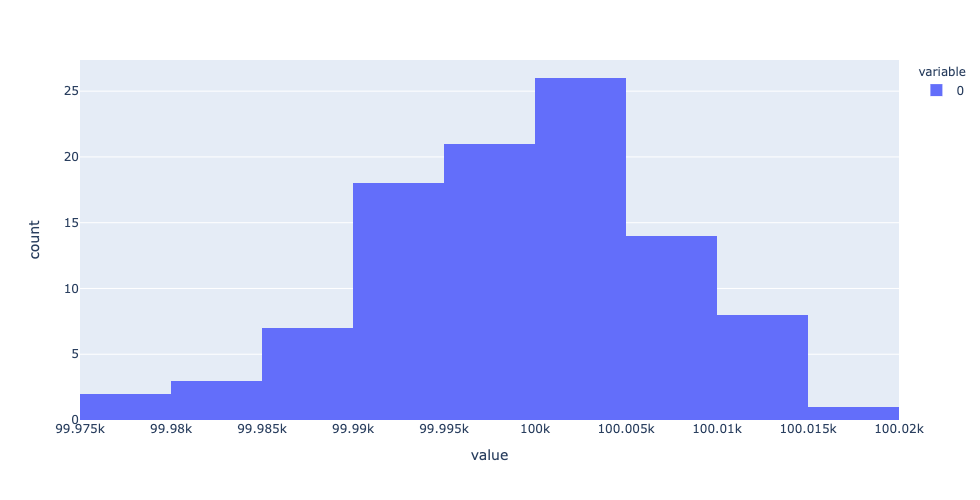

In [16]:
px.histogram(mixtures.sum(axis="rows"))

# set up cibersortx GEP imputation - "group" mode

In [17]:
base_path = os.path.abspath(os.path.join(results_dir, "group_mode"))

In [18]:
!sudo chown -R jupyter:jupyter $base_path
!rm -r $base_path
# os.makedirs(base_path, exist_ok=True)
# os.makedirs(os.path.join(base_path, "in"), exist_ok=True)
!mkdir -p $base_path/in

path = os.path.join(base_path, "in", "mixtures_computed.txt")
mixtures.to_csv(path, sep="\t")
print(path)

path = os.path.join(base_path, "fractions_known_and_empty_csx_metrics.txt")
fractions_and_empty_csx_metrics.to_csv(path, sep="\t")
print(path)

path = os.path.join(base_path, "in", "dummy_geps.txt")
sample_cell_type_geps.loc["sample_003"].to_csv(path, sep="\t")
print(path)

chown: cannot access '/home/jupyter/deconv/5d_results_noise_0.01/group_mode': No such file or directory
rm: cannot remove '/home/jupyter/deconv/5d_results_noise_0.01/group_mode': No such file or directory
/home/jupyter/deconv/5d_results_noise_0.01/group_mode/in/mixtures_computed.txt
/home/jupyter/deconv/5d_results_noise_0.01/group_mode/fractions_known_and_empty_csx_metrics.txt
/home/jupyter/deconv/5d_results_noise_0.01/group_mode/in/dummy_geps.txt


In [19]:
!tree -h $base_path

/home/jupyter/deconv/5d_results_noise_0.01/group_mode
├── [5.8K]  fractions_known_and_empty_csx_metrics.txt
└── [4.0K]  in
    ├── [2.2M]  dummy_geps.txt
    └── [ 31M]  mixtures_computed.txt

1 directory, 3 files


In [20]:
!docker run \
    --rm \
    -it \
    -v $base_path/in:/src/data \
    -v $base_path:/src/outdir \
    cibersortx/gep:latest \
    --username lyronctk@stanford.edu \
    --token dfeba2c8b9d61daebee5fa87026b8e56 \
    --mixture mixtures_computed.txt \
    --cibresults fractions_known_and_empty_csx_metrics.txt \
    --sigmatrix dummy_geps.txt

!sudo chown -R jupyter:jupyter $base_path

>Running CIBERSORTx GEP imputation (representative profiles only)...
>[Options] username: lyronctk@stanford.edu
>[Options] token: dfeba2c8b9d61daebee5fa87026b8e56
>[Options] mixture: mixtures_computed.txt
>[Options] cibresults: fractions_known_and_empty_csx_metrics.txt
>[Options] sigmatrix: dummy_geps.txt
>Previous estimates of cell proportions detected. To rerun, use redocibersort=TRUE.
>Loaded 100 mixture samples, 23686 genes, and 9 cell subsets...
>Imputing representative cell type GEPs...done.
>Writing output to disk...done.
>Running time (sec): 28


In [21]:
!tree -h $base_path

/home/jupyter/deconv/5d_results_noise_0.01/group_mode
├── [2.7M]  CIBERSORTxGEP_GEPs.txt
├── [3.5M]  CIBERSORTxGEP_GEPs_CVs.txt
├── [2.3M]  CIBERSORTxGEP_GEPs_Filtered.txt
├── [3.1M]  CIBERSORTxGEP_GEPs_Pvals.txt
├── [2.7M]  CIBERSORTxGEP_GEPs_Qvals.txt
├── [3.4M]  CIBERSORTxGEP_GEPs_StdErrs.txt
├── [555K]  CIBERSORTxGEP_GEPs_ThresholdPlots.pdf
├── [2.3M]  CIBERSORTxGEP_SM_GEPs_Filtered.txt
├── [6.7K]  CIBERSORTxGEP_Weights.txt
├── [5.8K]  fractions_known_and_empty_csx_metrics.txt
└── [4.0K]  in
    ├── [2.2M]  dummy_geps.txt
    └── [ 31M]  mixtures_computed.txt

1 directory, 12 files


In [22]:
pd.read_csv(
    os.path.join(base_path, "CIBERSORTxGEP_GEPs.txt"),
    sep="\t",
    index_col=0,
)

B        CAF  Endothelial  Macrophage  Malignant  \
GeneSymbol                                                             
A1BG         0.000000   3.449302     1.218887    2.936142   3.534771   
A1BG.AS1     4.523631   0.000000     1.543419    1.491642   0.954738   
A1CF         0.482329   0.569213     0.096800    0.317648   0.000000   
A2M          1.000000  19.714179    46.601063   20.435937  23.954235   
A2M.AS1      0.000000   3.045128     0.469099    0.000000   1.700877   
...               ...        ...          ...         ...        ...   
ZYG11A      10.348722   1.000000     6.215464    6.350079   3.961492   
ZYG11B       7.702083   6.234596     6.775215    4.755397   6.776641   
ZYX         10.995513  20.943121    17.559046   20.166733   5.086661   
ZZEF1        2.677051   3.990236     4.589793    6.458397   0.120003   
ZZZ3         5.231049   0.597943     4.316386    4.398794   5.325980   

                   NK      T CD4      T CD8     T.cell  
GeneSymbol                                              
A1BG         0.000000   0.712680   3.275812   0.921240  
A1BG.AS1     0.000000   1.752941   0.749723   3.341862  
A1CF         0.579876   0.822628   0.698248   0.112087  
A2M          1.000000   1.000000   1.000000   1.000000  
A2M.AS1      3.136097   2.355408   1.950546   3.292065  
...               ...        ...        ...        ...  
ZYG11A      11.282753  12.241303   9.492545  13.915583  
ZYG11B       7.366780  10.483070   7.688900  11.268941  
ZYX         15.764196   7.541847  13.477537   6.530852  
ZZEF1        3.778338   5.236241   4.991915   6.374636  
ZZZ3         0.212271   5.290186   7.066709   4.937811  

[23686 rows x 9 columns]

In [23]:
true_geps_on_average = sample_cell_type_geps.groupby(level=1).mean()

imputed_global_geps = pd.read_csv(
    os.path.join(base_path, "CIBERSORTxGEP_GEPs.txt"),
    sep="\t",
    index_col=0,
).set_index(true_geps_on_average.index)

both = pd.concat({
        "truth": true_geps_on_average,
        "imputed": imputed_global_geps
    },
    axis=1,
    names=["result", "cell_type"]
)

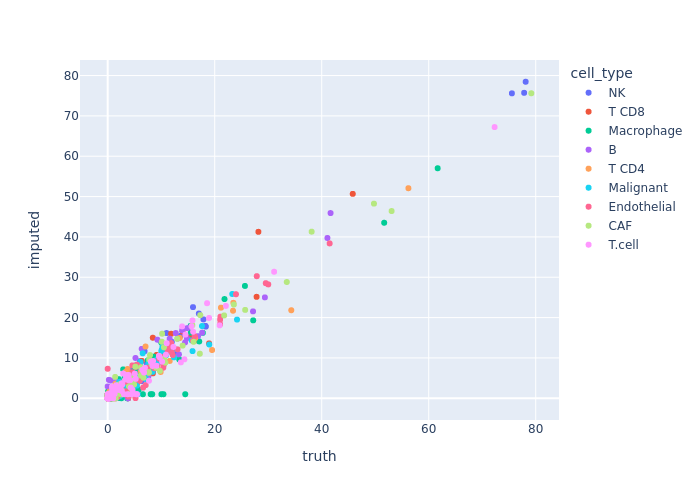

In [24]:
px.scatter(
    both.stack().reset_index().sample(1000),
    x="truth",
    y="imputed",
    color="cell_type"
)

# set up cibersortx GEP imputation - "hires" mode

In [25]:
# base_path = os.path.abspath("./5c_results/hires")
base_path = os.path.abspath(os.path.join(results_dir, "hires"))

In [26]:
!sudo chown -R jupyter:jupyter $base_path
!rm -r $base_path
!mkdir -p $base_path/in

path = os.path.join(base_path, "in", "mixtures_computed.txt")
mixtures.to_csv(path, sep="\t")
print(path)

path = os.path.join(base_path, "fractions_known.txt")
fractions.to_csv(path, sep="\t")
print(path)

chown: cannot access '/home/jupyter/deconv/5d_results_noise_0.01/hires': No such file or directory
rm: cannot remove '/home/jupyter/deconv/5d_results_noise_0.01/hires': No such file or directory
/home/jupyter/deconv/5d_results_noise_0.01/hires/in/mixtures_computed.txt
/home/jupyter/deconv/5d_results_noise_0.01/hires/fractions_known.txt


In [27]:
!tree -h $base_path

/home/jupyter/deconv/5d_results_noise_0.01/hires
├── [5.2K]  fractions_known.txt
└── [4.0K]  in
    └── [ 31M]  mixtures_computed.txt

1 directory, 2 files


In [28]:
!rm $base_path/CIBERSORT*

!docker run \
    --rm \
    -it \
    -v $base_path/in:/src/data \
    -v $base_path:/src/outdir \
    cibersortx/hires:latest \
    --username lyronctk@stanford.edu \
    --token dfeba2c8b9d61daebee5fa87026b8e56 \
    --mixture mixtures_computed.txt \
    --cibresults fractions_known.txt

'''
    --sigmatrix cell_type_geps_known.txt
'''

!sudo chown -R jupyter:jupyter $base_path

rm: cannot remove '/home/jupyter/deconv/5d_results_noise_0.01/hires/CIBERSORT*': No such file or directory
>Running CIBERSORTx high-resolution GEP imputation...
>[Options] username: lyronctk@stanford.edu
>[Options] token: dfeba2c8b9d61daebee5fa87026b8e56
>[Options] mixture: mixtures_computed.txt
>[Options] cibresults: fractions_known.txt
>Loaded 100 mixture samples, 23686 genes, and 9 cell subsets...
>Window size adaptively set to 36
>Imputing high-resolution cell type GEPs...done.
>Writing output to disk ...done.
>Running time (sec): 352


In [29]:
!tree -h $base_path

/home/jupyter/deconv/5d_results_noise_0.01/hires
├── [ 46M]  CIBERSORTxHiRes_NA_B_Window36.txt
├── [ 46M]  CIBERSORTxHiRes_NA_CAF_Window36.txt
├── [ 46M]  CIBERSORTxHiRes_NA_Endothelial_Window36.txt
├── [103K]  CIBERSORTxHiRes_NA_Heatmap_B_Window36.png
├── [129K]  CIBERSORTxHiRes_NA_Heatmap_CAF_Window36.png
├── [141K]  CIBERSORTxHiRes_NA_Heatmap_Endothelial_Window36.png
├── [ 66K]  CIBERSORTxHiRes_NA_Heatmap_Macrophage_Window36.png
├── [134K]  CIBERSORTxHiRes_NA_Heatmap_Malignant_Window36.png
├── [153K]  CIBERSORTxHiRes_NA_Heatmap_NK_Window36.png
├── [154K]  CIBERSORTxHiRes_NA_Heatmap_T.cell_Window36.png
├── [162K]  CIBERSORTxHiRes_NA_Heatmap_TCD4_Window36.png
├── [185K]  CIBERSORTxHiRes_NA_Heatmap_TCD8_Window36.png
├── [ 46M]  CIBERSORTxHiRes_NA_Macrophage_Window36.txt
├── [ 46M]  CIBERSORTxHiRes_NA_Malignant_Window36.txt
├── [ 46M]  CIBERSORTxHiRes_NA_NK_Window36.txt
├── [ 46M]  CIBERSORTxHiRes_NA_T.cell_Window36.txt
├── [ 46M]  CIBERSORTxHiRes_NA_TCD4_Window36.txt
├── [ 46M]  CIBERS

In [30]:
inferred_cell_type_geps = dict()
standard_gene_index = sample_cell_type_geps["B"].loc["sample_000"].index

for path in glob.glob(os.path.join(base_path, "CIBERSORTxHiRes_NA_*_Window*txt")):
    file = os.path.basename(path)
    cell_type = file.split("_")[2]
    print(cell_type)
    df = pd.read_csv(path, sep="\t", index_col=0).rename_axis(columns="sample")
    df = df.set_index(standard_gene_index)
    inferred_cell_type_geps[cell_type] = df

all_inferred_geps = \
    pd.concat(inferred_cell_type_geps, names=["cell_type"])\
    .stack()\
    .reset_index()\
    .set_index(['sample', 'GeneSymbol', 'cell_type'])\
    .unstack(level=-1)[0]\
    .rename(columns=weird_to_nice)

NK
Endothelial
B
TCD4
Macrophage
CAF
Malignant
TCD8
T.cell


In [31]:
all_inferred_geps.head(10)

cell_type                     B        CAF  Endothelial  Macrophage  \
sample     GeneSymbol                                                 
sample_000 A1BG        1.000000   4.365710     1.000000    3.003120   
           A1BG-AS1    6.044315   1.000000     1.000000    1.000000   
           A1CF        1.000000   1.000000     1.000000    1.000000   
           A2M         1.000000  24.616857    48.369551   24.143638   
           A2M-AS1     1.000000   1.000000     1.000000    1.000000   
           A2ML1       1.000000   1.000000     1.725699    1.000000   
           A2MP1       1.000000   1.000000     1.000000    1.000000   
           A4GALT      1.000000   5.102656     3.531734    1.000000   
           A4GNT       1.000000   1.000000     1.000000    1.000000   
           AA06        1.000000   1.000000     1.000000    1.000000   

cell_type              Malignant        NK    T.cell     T CD4     T CD8  
sample     GeneSymbol                                                     
sample_000 A1BG         4.520239  1.000000  1.000000  1.000000  4.912388  
           A1BG-AS1     1.000000  1.000000  6.430116  7.405217  1.000000  
           A1CF         1.000000  1.000000  1.000000  1.000000  1.000000  
           A2M         26.228468  1.000000  1.000000  1.000000  1.000000  
           A2M-AS1      1.000000  1.192531  1.022348  1.000000  1.000000  
           A2ML1        1.000000  1.176570  2.013264  2.405088  1.705576  
           A2MP1        1.000000  1.000000  1.000000  1.000000  1.000000  
           A4GALT       1.000000  1.000000  1.000000  1.000000  1.000000  
           A4GNT        1.000000  1.000000  1.000000  1.000000  1.000000  
           AA06         1.000000  1.000000  1.000000  1.000000  1.000000

In [32]:
truth_and_imputed = pd.concat(
    {
        "truth": sample_cell_type_geps,
        "imputed": all_inferred_geps
    },
    axis=0,
    names=["result", "sample", "GeneSymbol"]
).stack().unstack(0).reset_index()

In [33]:
truth_and_imputed

result        sample GeneSymbol    cell_type      truth    imputed
0         sample_000       A1BG            B   0.000000   1.000000
1         sample_000       A1BG          CAF   2.939188   4.365710
2         sample_000       A1BG  Endothelial   0.000000   1.000000
3         sample_000       A1BG   Macrophage   3.545610   3.003120
4         sample_000       A1BG    Malignant   0.000000   4.520239
...              ...        ...          ...        ...        ...
21317395  sample_099       ZZZ3    Malignant  12.695014   6.238408
21317396  sample_099       ZZZ3           NK   4.272592   1.000000
21317397  sample_099       ZZZ3        T CD4   2.300593   7.822542
21317398  sample_099       ZZZ3        T CD8  15.426392  16.326268
21317399  sample_099       ZZZ3       T.cell   1.182247  16.340686

[21317400 rows x 5 columns]

In [34]:
# truth = sample_cell_type_geps["B"].unstack(level=0)

# imputed = pd.read_csv(
#     os.path.join(base_path, "CIBERSORTxHiRes_NA_B_Window36.txt"),
#     sep="\t",
#     index_col=0
# ).set_index(truth.index)

# truth_and_imputed = pd.concat(
#     {
#         "truth": truth,
#         "imputed": imputed
#     },
#     axis=1,
# #     names=["result"]
# ).stack()

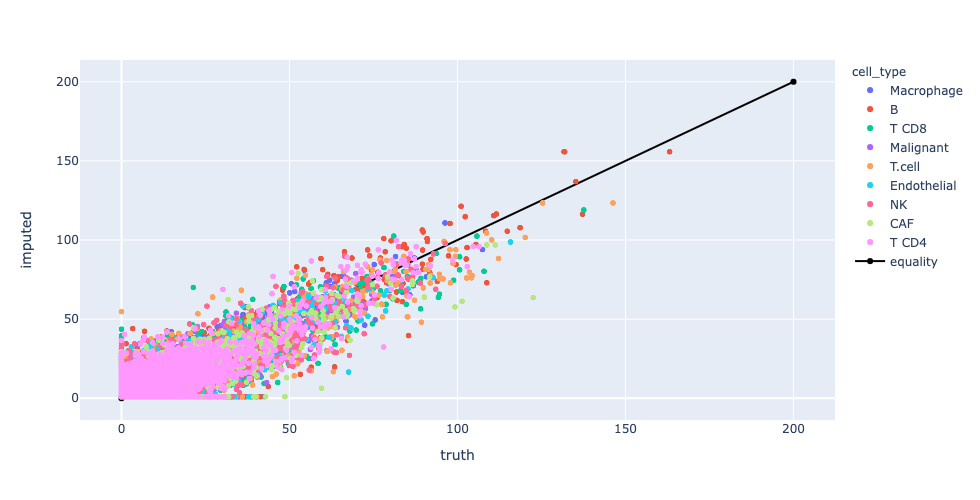

In [35]:
fig = px.scatter(
    truth_and_imputed.sample(100000),
    x="truth",
    y="imputed",
    color="cell_type"
)

fig.add_trace(go.Scatter(x=[0, 200], y=[0, 200], line=dict(color='black'), name='equality'))

fig